In [1]:
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import pandas as pd

In [2]:
reservoirsShapefilePath = 'reservoirsShapefile/'
aoi2Path = reservoirsShapefilePath + 'aoi2reservoirs'
aoi2Reservoirs = gpd.read_file(aoi2Path)

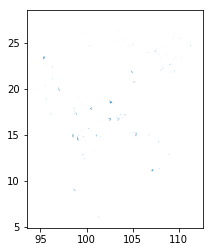

In [3]:
aoi2Reservoirs.plot()

In [4]:
mekong_basin_file = 'mekongShapefile/hybas_as_lev03_v1c/hybas_as_lev03_v1c.shp'

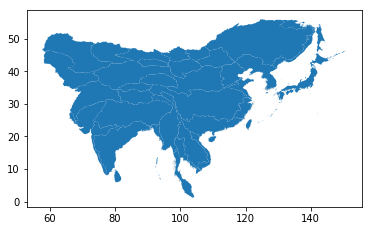

In [5]:
df = gpd.read_file(mekong_basin_file)
df.plot()

In [6]:
import os
print(os.getcwd())

/home/tron/python/mekongReservoirs


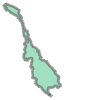

In [7]:
# Mekong Basin has the index 11 in the HYBAS_ID
mekong_basin_id = 4030017020
df.set_index('HYBAS_ID').loc[mekong_basin_id].geometry

In [8]:
mekong_basin_shape = df.set_index('HYBAS_ID').loc[mekong_basin_id].geometry
mekong_crs = df.crs

In [9]:
import fiona
from rasterio.warp import transform_geom
from shapely.geometry import shape, mapping

class MekongShape(object):
    
    def __init__(self, shape, crs):
        self.shape = shape
        self.crs = crs
    
    def intersects(self, geom, crs):
        if not isinstance(geom, dict):  
            geom = mapping(geom)            
        geom = shape(transform_geom(crs, self.crs, geom))
        return self.shape.intersects(geom)

In [10]:
countryShapefilePath = 'CountryShapefile/'
vnShapefilePath = countryShapefilePath + 'vnShapefile/VNM_adm1.shp'
laShapefilePath = countryShapefilePath + 'laShapefile/LAO_adm1.shp'
cbShapefilePath = countryShapefilePath + 'cbShapefile/KHM_adm1.shp'
tlShapefilePath = countryShapefilePath + 'tlShapefile/THA_adm1.shp'

In [11]:
countryShapefile = {}
countryShapefile['VNM'] = gpd.read_file(vnShapefilePath)
countryShapefile['LAO'] = gpd.read_file(laShapefilePath)
countryShapefile['KHM'] = gpd.read_file(cbShapefilePath)
countryShapefile['THA'] = gpd.read_file(tlShapefilePath)

In [12]:
mekongCountriesShapefile = countryShapefile['VNM'].copy()
mekongCountriesShapefile = mekongCountriesShapefile.append(countryShapefile['LAO'])
mekongCountriesShapefile = mekongCountriesShapefile.append(countryShapefile['KHM'])
mekongCountriesShapefile = mekongCountriesShapefile.append(countryShapefile['THA'])

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


# Overlay countries, reservoirs and Mekong basin

In [13]:
def overlayBasinAndReservoirs(countryShapefile, 
                              mekongShape=None, 
                              reservoirsShapefile=None, 
                              ax=None, 
                              figsize=20, 
                              reservoirScale=1.0):
    
    from matplotlib.collections import PatchCollection
    from shapely.geometry import Polygon, MultiPolygon, shape, box, Point
    from shapely.affinity import scale
    from descartes import PolygonPatch
    from matplotlib import pyplot as plt

    if ax is None:
        fig = plt.figure(figsize = (figsize,figsize))
        ax = fig.add_subplot(111)

    shapes = [shape(p) for p in countryShapefile['geometry']]
    mp = MultiPolygon(shapes)
    xmin, ymin, xmax, ymax = mp.bounds
    w, h = xmax - xmin, ymax - ymin

    ax.set_xlim(xmin - 0.2 * w, xmax + 0.2 * w)
    ax.set_ylim(ymin - 0.2 * h, ymax + 0.2 * h)
    ax.set_aspect(1.0)

    patches = []
    for provinceShape in shapes:
        patches.append(PolygonPatch(provinceShape, fc='none', ec='#555555', zorder=0))
    
    if mekongShape is not None:
        p = shape(mekongShape)
        patches.append(PolygonPatch(p, fc='aqua', ec='green', zorder=1))
    
    if reservoirsShapefile is not None:
        for reservoirShapefile in reservoirsShapefile['geometry']:
            p = shape(reservoirShapefile)
            p = scale(p, xfact=reservoirScale, yfact=reservoirScale)
            patches.append(PolygonPatch(p, fc='blue', ec='#555555', zorder=1))
    
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)
    ax.axis('off')
    
    plt.show()
    return ax

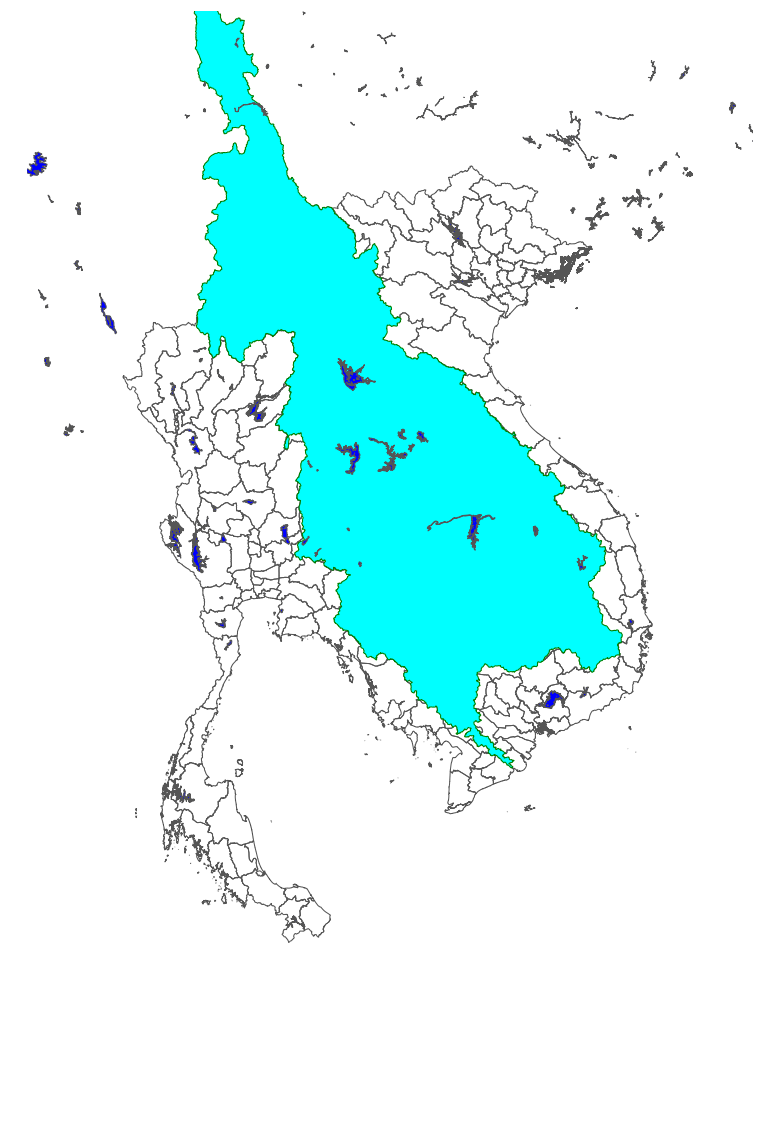

In [14]:
overlayBasinAndReservoirs(countryShapefile=mekongCountriesShapefile,
                          mekongShape=mekong_basin_shape,
                          reservoirsShapefile=aoi2Reservoirs,
                          reservoirScale=2.0)

In [15]:
def getBound(shape):
    from shapely.geometry import Polygon, MultiPolygon, box, Point
    mp = Polygon(shape)
    return mp.bounds

In [16]:
def calArea(geom):
    import pyproj
    import shapely.ops as ops
    from functools import partial
    geom_area = ops.transform(
        partial(
            pyproj.transform,
            pyproj.Proj(init='EPSG:4326'),
            pyproj.Proj(
                proj='aea',
                lat1=geom.bounds[1],
                lat2=geom.bounds[3])),
        geom)
    return geom_area.area/1000000

In [17]:
HydroLAKESPath = reservoirsShapefilePath + 'HydroLAKES_polys_v10_shp'
HydroLAKES = gpd.read_file(HydroLAKESPath)

In [18]:
HydroLAKES.columns

Index(['Hylak_id', 'Lake_name', 'Country', 'Continent', 'Poly_src',
       'Lake_type', 'Grand_id', 'Lake_area', 'Shore_len', 'Shore_dev',
       'Vol_total', 'Vol_res', 'Vol_src', 'Depth_avg', 'Dis_avg', 'Res_time',
       'Elevation', 'Slope_100', 'Wshd_area', 'Pour_long', 'Pour_lat',
       'geometry'],
      dtype='object')

In [20]:
seaCountries = ['Vietnam', 'Laos', 'Cambodia', 'Thailand', 'Myanmar', 'China']
seaLakes = HydroLAKES[HydroLAKES['Country'].isin(seaCountries)]

In [21]:
mekongShape = MekongShape(mekong_basin_shape, df.crs)
mekongReservoirs = pd.DataFrame(columns=['Lake_name', 'Country', 'Lake_area', 'geometry'])
crs = seaLakes.crs
from shapely.geometry import shape
for index, row in seaLakes.iterrows():
    geom = row['geometry']
    if mekongShape.intersects(geom, crs):
        mekongReservoirs = mekongReservoirs.append({'Lake_name': row['Lake_name'],
                                                    'Country': row['Country'],
                                                    'Lake_area': row['Lake_area'],
                                                    'geometry': geom},
                                                   ignore_index=True)

In [22]:
mekongReservoirs.iloc[:10]

,Lake_name,Country,Lake_area,geometry
0,Tonle Sap,Cambodia,2415.98,"POLYGON ((103.7116620551215 13.25956420898444,..."
1,Erh,China,242.26,"POLYGON ((100.1527031962074 25.95278835720489,..."
2,,Laos,436.93,"POLYGON ((102.4854543728269 18.79431328667579,..."
3,Ubol Ratana,Thailand,313.38,"POLYGON ((102.5829117838511 16.87836941189278,..."
4,Lam Pao,Thailand,202.51,"POLYGON ((103.2596035348592 16.96004430411114,..."
5,Noi,Thailand,235.58,"POLYGON ((105.3705555555522 14.95277777777733,..."
6,,China,36.91,"POLYGON ((100.3037651913646 24.76341933108557,..."
7,,Thailand,18.22,"POLYGON ((99.86766547309037 19.20068786621135,..."
8,,Thailand,11.00,"POLYGON ((103.6993028428789 18.31263617621573,..."
9,,Laos,12.49,"POLYGON ((102.4331529405351 18.30951470269144,..."


In [23]:
mekongReservoirs.to_csv('mekongReservoirs.csv')

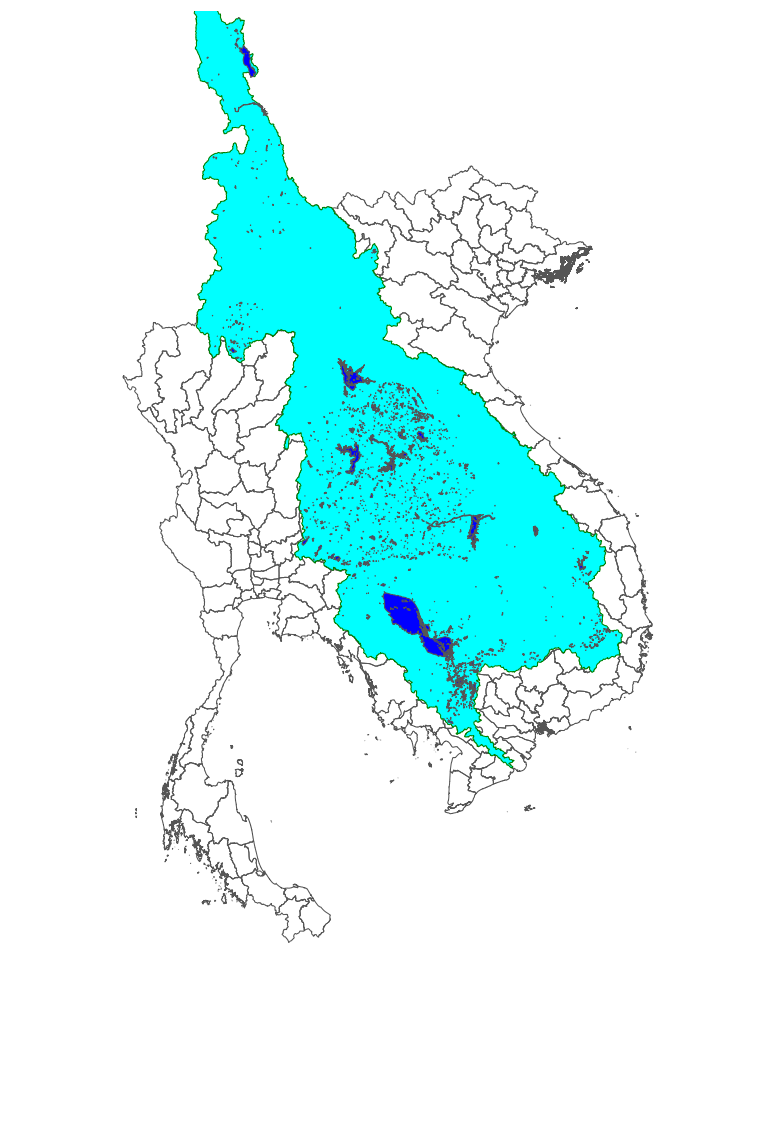

In [24]:
overlayBasinAndReservoirs(countryShapefile=mekongCountriesShapefile,
                          mekongShape=mekong_basin_shape,
                          reservoirsShapefile=mekongReservoirs,
                          reservoirScale=2.0)